In [41]:
# import libraries

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np

import time

# Pandas warning messages (optional)
pd.options.mode.chained_assignment = None  #default='warn'

# Plot options
import matplotlib.pyplot as plt
import seaborn as sns
sns.palplot(sns.color_palette('deep'))
sns.set_style("whitegrid")
%matplotlib inline

In [2]:
df_raw = pd.read_csv('data/listings_cleaned.csv', low_memory=False)

In [25]:
features_list = ['room_type', 'bathrooms', 'bedrooms', 'accommodates', 
                 'host_is_superhost',  'region', 'review_scores_rating', 'number_of_reviews']

# Create features and price DFs for sklearn inputs
features = df_raw[features_list].copy()   # 'X'
target = df_raw['price'].copy()            # 'y'

In [26]:
# Create dummy variables for 'room type', 'superhost' and 'region'
features = pd.get_dummies(X)
features.head()

,bathrooms,bedrooms,accommodates,review_scores_rating,number_of_reviews,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,host_is_superhost_f,host_is_superhost_t,region_Central,region_East,region_North,region_South,region_West
0,2.0,2.0,4,93.0,24,1,0,0,0,0,1,1,0,0,0,0
1,1.0,1.0,2,91.0,9,0,0,1,0,0,1,1,0,0,0,0
2,1.0,1.0,3,97.0,529,1,0,0,0,0,1,1,0,0,0,0
3,1.0,1.0,2,98.0,257,0,0,1,0,0,1,0,0,1,0,0
4,1.0,0.0,2,99.0,112,1,0,0,0,0,1,1,0,0,0,0


In [27]:
# Scale the quantitative features
# Note: using RobustScaler resulted in similar r2 results
scaler = MinMaxScaler()
numerical = ['bathrooms', 'bedrooms', 'review_scores_rating', 'accommodates', 'number_of_reviews']
features_scaled = df.copy()
features_scaled[numerical] = scaler.fit_transform(features_scaled[numerical])

In [28]:
features_scaled.head()

,bathrooms,bedrooms,accommodates,review_scores_rating,number_of_reviews,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,host_is_superhost_f,host_is_superhost_t,region_Central,region_East,region_North,region_South,region_West
0,0.250,0.142857,0.200000,0.9125,0.025343,1,0,0,0,0,1,1,0,0,0,0
1,0.125,0.071429,0.066667,0.8875,0.009504,0,0,1,0,0,1,1,0,0,0,0
2,0.125,0.071429,0.133333,0.9625,0.558606,1,0,0,0,0,1,1,0,0,0,0
3,0.125,0.071429,0.066667,0.9750,0.271383,0,0,1,0,0,1,0,0,1,0,0
4,0.125,0.000000,0.066667,0.9875,0.118268,1,0,0,0,0,1,1,0,0,0,0


In [29]:
features_scaled.to_csv('data/listings_scaled.csv')

### Modeling:

In [31]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, 
                                                    target, 
                                                    test_size = .30, 
                                                    random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Test set has {} samples.".format(X_test.shape[0]))

Training set has 7961 samples.
Test set has 3412 samples.


In [32]:
models = [SVR(kernel='linear'),
          DecisionTreeRegressor(),
          LinearRegression(),
          KNeighborsRegressor(n_neighbors=7),
          RandomForestRegressor(n_estimators=100)]

results = {}

for model in models:
    
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train)
    
    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)
    
    # Grab model name and store results associated with model
    name = str(model).split("(")[0]
    results[name] = r2_score(y_test, y_test_preds)
    
print(results)

{'SVR': 0.11118582559484236, 'DecisionTreeRegressor': -0.1248429061643146, 'LinearRegression': 0.2970916762527054, 'KNeighborsRegressor': 0.3204931265914249, 'RandomForestRegressor': 0.3263293453675755}


In [43]:
# Training Decision Tree Classifier Model
modelDTR = DecisionTreeRegressor()

modelDTR.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [44]:
# Accuracy score for Decision Tree
y_pred = modelDTR.predict(X_test)
scoreDTR = accuracy_score(y_pred, y_test)
print('Decision Tree Regressor accuracy: {:.2f}'.format(scoreDTR))

ValueError: Classification metrics can't handle a mix of continuous and multiclass targets

In [49]:
# Using GridSearchCV on DecisionTreeClassifier
#create a dictionary of all values we want to test
param_dist = {"max_depth": np.arange(1, 21),
              #"max_features": randint(1, 9),
              "min_samples_leaf": [1, 5, 10, 20, 50, 100],
              #"criterion": ["gini", "entropy"]
             }
#use gridsearch to test all values
tree_cv = GridSearchCV(DecisionTreeRegressor(), param_dist, cv=5)
#fit model to data
tree_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]),
                     

In [50]:
print(tree_cv.best_params_)
print(accuracy_score(tree_cv.predict(X_test), y_test))

{'max_depth': 11, 'min_samples_leaf': 20}


ValueError: Classification metrics can't handle a mix of continuous and multiclass targets

In [51]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

Time taken to run: 0.0 minutes

Training MSE: 40470.112
Validation MSE: 138303.1143

Training r2: 0.8103
Validation r2: 0.2856


Text(0.5, 1.0, 'Comparison of Regression Models')

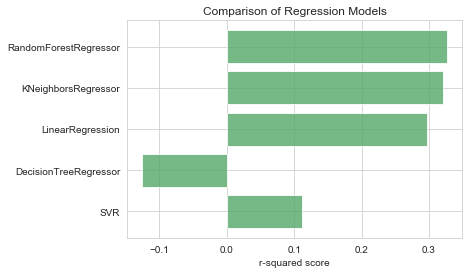

In [52]:
fig, ax = plt.subplots()

ind = range(len(results))
ax.barh(ind, list(results.values()), align='center', 
        color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(results.keys())
ax.set_xlabel('r-squared score')
ax.tick_params(left=False, top=False, right=False) 
ax.set_title('Comparison of Regression Models')
#fig.savefig('images/compare_models.png', bbox_inches = 'tight')